In [ ]:
# 필요한 package 불러오기

%pylab inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


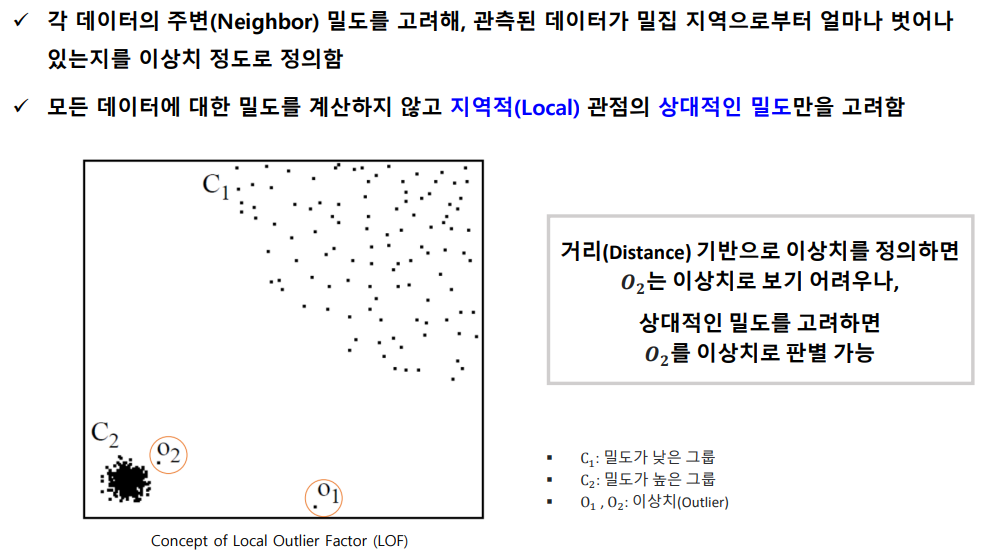

## (1) LOF (Local Outlier Factor) Algorithm

In [ ]:
# Gnerated dataset

np.random.seed(2)

dim = 2 # number of dimensions of dataset = 2

# cluster of normal random variable moderately dense
data1 = np.random.multivariate_normal([0, 1500], [[100000, 0], [0, 100000]], 2000) # mean, cov, number of samples

# very dense
data2 = np.random.multivariate_normal([2000, 0], [[10000, 0], [0, 10000]], 2500)

# sparse
data3 = np.random.multivariate_normal([2500, 2500], [[100000, 0], [0, 100000]], 500)

# mix the three dataset and shuffle
data = np.vstack((np.vstack((data1, data2)), data3))
np.random.shuffle(data)

# add some noise : zipf is skewed distribution and can have extreme values(outliers)
zipf_alpha = 2.25 # distribution parameter (should be greater than 1)
noise = np.random.zipf(zipf_alpha, (5000,dim)) * np.sign((np.random.randint(2, size = (5000, dim)) - 0.5)) # zeta distribution / randint: 정수 난수 생성
data += noise

data.shape

(5000, 2)

> Distance 정의

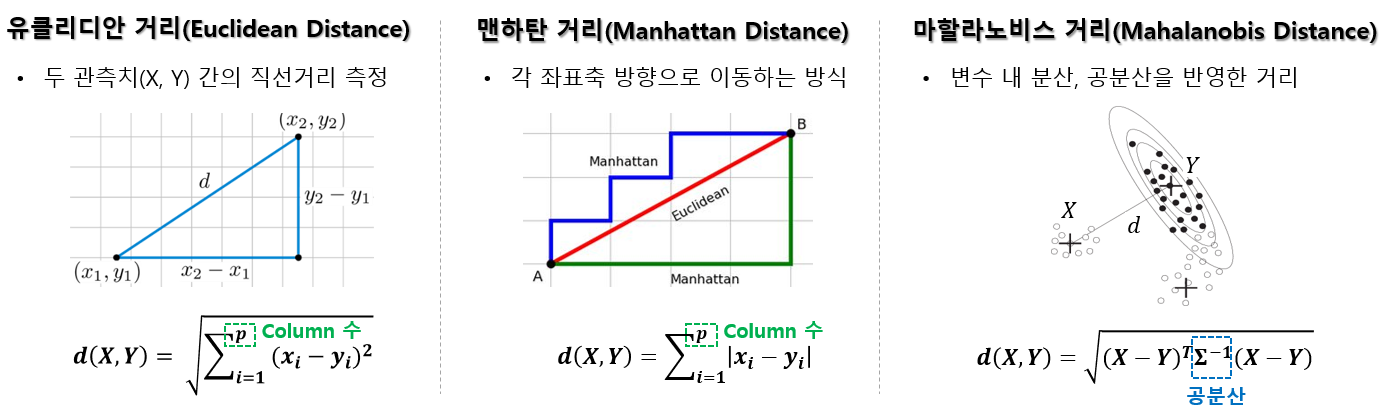

In [ ]:
 # distance between points (Euclidean)

tic = time.time()

dist = DistanceMetric.get_metric('euclidean').pairwise(data)
print('++ took %g msecs for Distance computation' %  ((time.time() - tic)* 1000))

++ took 176.745 msecs for Distance computation


/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [ ]:
dist.shape # dist: 총 5000개 samples 간의 거리 계산

(5000, 5000)

> Radius

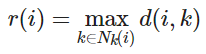

In [ ]:
tic = time.time()

k = 17 # number of neighbors to consider

# get the radius for each point in dataset (distance to kth nearest neighbor)
# radius is the distance of kth nearest point for each point in dataset        

idx_knn = np.argsort(dist, axis=1)[:,1 : k + 1] # by row' get k nearest neighbour   
radius = np.linalg.norm(data - data[idx_knn[:, -1]], axis = 1) # 1-norm

print('+++ took %g msecs for KNN Querying' %  ((time.time() - tic)* 1000))

+++ took 3011.88 msecs for KNN Querying


In [ ]:
radius

array([52.53851961, 28.08261004, 22.55848815, ..., 12.93692865,
       48.51320503, 44.8090923 ])

In [ ]:
print(idx_knn.shape)
print(radius.shape)

(5000, 17)
(5000,)


> Reach distance (rd) & Local Reachability Distance (LRD)

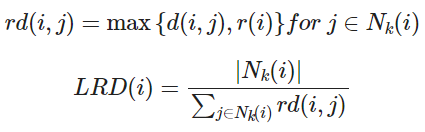

In [ ]:
# calculate the local reachability density
tic = time.time()

LRD = []
for i in range(idx_knn.shape[0]):
    LRD.append(np.mean(np.maximum(dist[i, idx_knn[i]], radius[idx_knn[i]])))

print('++++ took %g msecs for LRD computation' %  ((time.time() - tic)* 1000))

++++ took 113.322 msecs for LRD computation


In [ ]:
LRD[:5]

[55.949633023266294,
 26.438563741309263,
 23.36944503654888,
 17.144816315832262,
 19.49672777793099]

In [ ]:
print(len(LRD))

5000


> Local Outlier Factor (LOF)

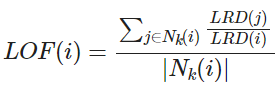

In [ ]:
# calculating the outlier score
tic = time.time()

rho = 1. / np.array(LRD) # inverse of density

outlier_score = np.sum(rho[idx_knn], axis = 1)/ np.array(rho, dtype = np.float16)
outlier_score *= 1./k

print('+++++ took %g msecs for Outlier scoring' %  ((time.time() - tic)* 1000))

+++++ took 7.52926 msecs for Outlier scoring


In [ ]:
outlier_score

array([0.99184481, 1.03122308, 1.01774952, ..., 1.00576344, 0.98053696,
       1.04538116])

In [ ]:
print(outlier_score.shape)

(5000,)


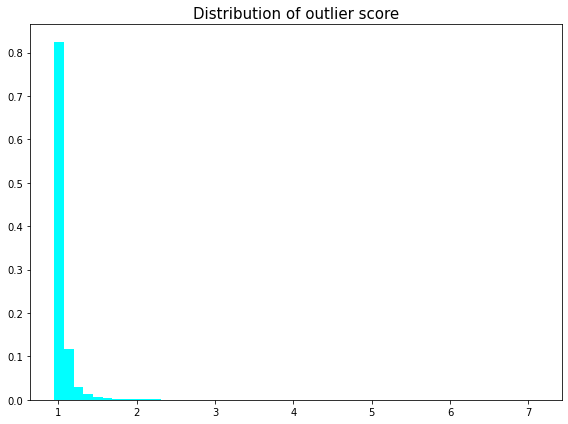

In [ ]:
'''
# the histogram of Outlier score, to choose the optimal threshold to decid weather a data-point is outlier is not.
# the optimal outlier score threshold to decide weather a data-point is outlier is outlier or not is around 2 for most of the cases
'''
weights = np.ones_like(outlier_score)/outlier_score.shape[0] # to normalize the histogram to probability plot

# visualize
plt.figure(figsize = (8, 6))
plt.hist(outlier_score, bins = 50, weights = weights, histtype = 'stepfilled', color = 'cyan')
plt.title('Distribution of outlier score', fontsize = 15)
plt.tight_layout()
plt.show()

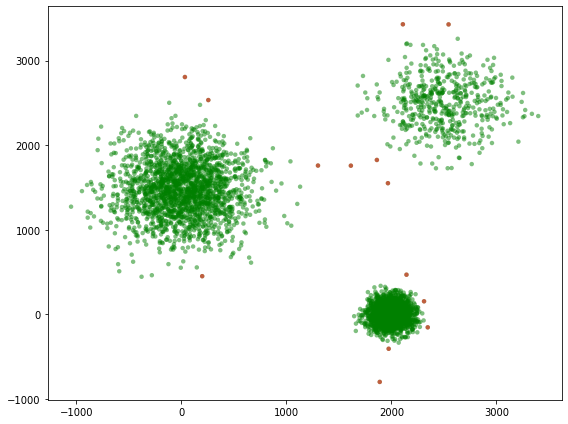

In [ ]:
threshold = 2.

# plot non outliers as green
plt.figure(figsize = (8, 6))
plt.scatter(data[:, 0], data[:, 1], c = 'green', s = 20, edgecolors='None', alpha=0.5)

# find the outliers and plot te outliers
idx = np.where(outlier_score > threshold)
plt.scatter(data[idx, 0], data[idx, 1], c = 'red', s = 20, edgecolors='None', alpha=0.5)
plt.tight_layout()
plt.show()

## (2) Comparison with DBSCAN, LOF, GMM, k-means

In [ ]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0708.git

Cloning into 'DX-Training-LGES-0708'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 60 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), 6.93 MiB | 3.96 MiB/s, done.


In [ ]:
# load the dataset

data= pd.read_csv("/content/DX-Training-LGES-0708/Data/CTG.csv")
data.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,9.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1.0


In [ ]:
data = data.dropna()
data.shape

(2126, 33)

In [ ]:
X = data.iloc[:, :-1] # input variables
y = data.iloc[:, -1] # target variables

In [ ]:
len(y==2)

2126

In [ ]:
# Principal Component Analysis (PCA) to reduce the dimension 

pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)
X_pca

array([[ 20.98170344,  44.70059044],
       [ 61.83544298, -30.34380634],
       [ 62.57294482, -29.15162753],
       ...,
       [-21.57001065, -26.69032929],
       [-23.18666646, -24.71838415],
       [-49.58638982,  -8.40753684]])

In [ ]:
# fit the model for outlier detection 
# use the default value of 20 nearest neighbors to measure the local deviation of the density

'''
LOF parameter
  - n_neighbors: Number of neighbors
  - metric: Metric to use for distance computation (default is minkowski, which results in the standard Euclidean distance when p=2)
  - contamination: the proportion of outliers
'''
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [ ]:
# use fit_predict to compute the predicted labels of the training samples

y_pred = clf.fit_predict(X_pca)
n_errors = (y_pred != y).sum()
X_scores = clf.negative_outlier_factor_

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
pd.DataFrame(y_pred)[0].value_counts() # -1: outliers

 1    1913
-1     213
Name: 0, dtype: int64

In [ ]:
n_errors

601

In [ ]:
X_scores

array([-1.10989839, -1.00758086, -1.00749347, ..., -0.96695581,
       -0.9949099 , -0.99458377])

In [ ]:
# make the results to the dataframe
results = pd.concat([pd.DataFrame(y_pred)[0], pd.DataFrame(X_scores)[0]], axis=1)
results.columns = ['Pred', 'LOF Scores']
results

,Pred,LOF Scores
0,1,-1.109898
1,1,-1.007581
2,1,-1.007493
3,1,-0.945407
4,1,-0.991346
...,...,...
2121,1,-1.008887
2122,1,-0.979128
2123,1,-0.966956
2124,1,-0.994910


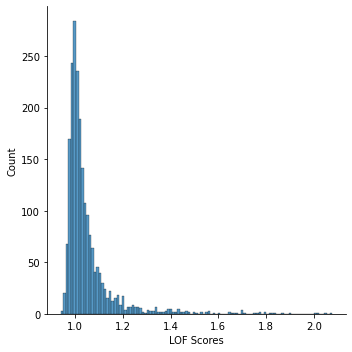

In [ ]:
# distribution plot of LOF scores
sns.displot(np.abs(results['LOF Scores']))
plt.show()

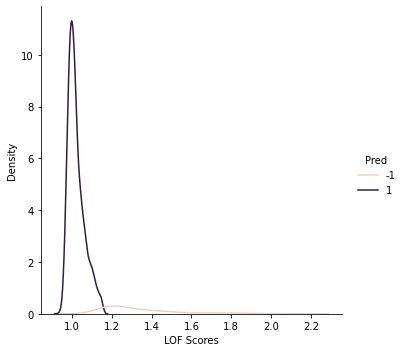

In [ ]:
# distribution plot of LOF scores
sns.displot(data=results, x=np.abs(results["LOF Scores"]), hue="Pred", kind="kde")
plt.show()

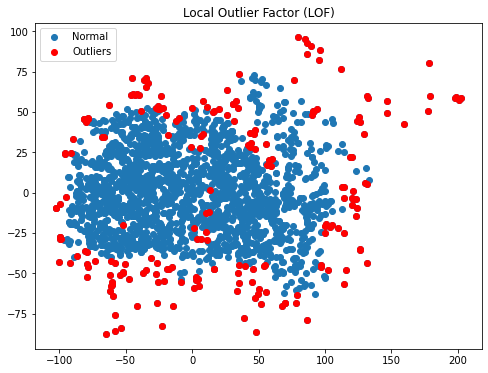

In [ ]:
# Visualize the outliers using matplotlib, where the LOF score is not 1.

lofs_index = np.where(y_pred!=1)
values = X_pca[lofs_index]

plt.figure(figsize = (8, 6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_pca[:,0], X_pca[:,1], label="Normal")
plt.scatter(values[:,0],values[:,1], color='r', label="Outliers")
plt.legend(loc="upper left")
plt.show()

## (3) Comparison with DBSCAN, LOF, GMM, k-means

<ipython-input-20-8d65ff5890dc>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X1[:, 0], X1[:, 1], c=None, s=2, cmap='viridis');


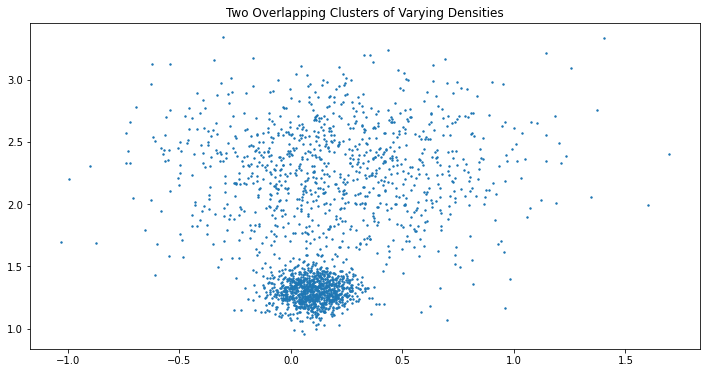

In [ ]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [0.1,  1.3]])

blob_std = np.array([0.4, 0.1])

X1, y1 = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

plt.figure(figsize=(12, 6))
plt.title("Two Overlapping Clusters of Varying Densities")
plt.scatter(X1[:, 0], X1[:, 1], c=None, s=2, cmap='viridis');
plt.show()

Cluster IDs:  [-1  0  1]


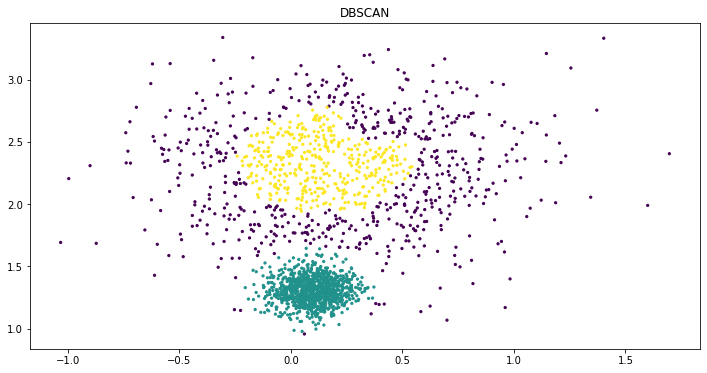

In [ ]:
# Train the DBSCAN model
dbscan1 = DBSCAN(eps=0.08, min_samples=17)
dbscan1.fit(X1)

print("Cluster IDs: ", np.unique(dbscan1.labels_))

# visualize the DBSCAN result
plt.figure(figsize=(12, 6))
plt.title("DBSCAN")
plt.scatter(X1[:, 0], X1[:, 1], c=dbscan1.labels_, s=5, cmap='viridis')
plt.show()

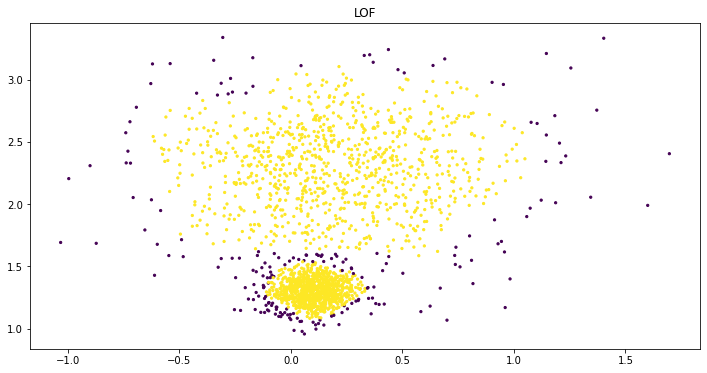

In [ ]:
# Train the LOF model
lof = LocalOutlierFactor(n_neighbors=40, metric='minkowski', p=2, contamination=0.1)

# visualize the LOF result
plt.figure(figsize=(12, 6))
plt.title("LOF")
plt.scatter(X1[:, 0], X1[:, 1], c=lof.fit_predict(X1), s=5, cmap='viridis')
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


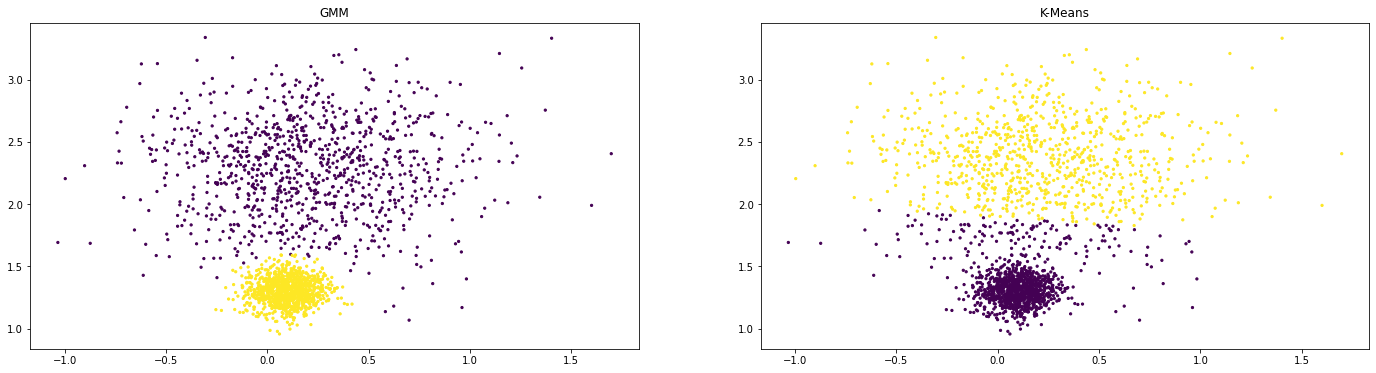

In [ ]:
# Train the GMM
gmm1=GaussianMixture(n_components=2, n_init=10, random_state=42)
gmm1.fit(X1)

# Train the K-Means model
kmeans1=KMeans(n_clusters=2, random_state=42)
kmeans1.fit(X1)

# visualize the GMM result
plt.figure(figsize=(24, 6))
plt.subplot(121)
plt.title("GMM")
plt.scatter(X1[:, 0], X1[:, 1], c=gmm1.predict(X1), s=5, cmap='viridis')

# visualize the k-means result
plt.subplot(122)
plt.title("K-Means")
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans1.fit_predict(X1), s=5, cmap='viridis')
plt.show()